# Exploratory Data Analysis of Crack Morphology
Shantanu Motiani (13757830) 
MSc IS:DS

## Introduction
This notebook presents an in-depth exploration of a crack segmentation dataset with a focus on unsupervised learning techniques for feature extraction and pattern discovery in crack morphology. This analysis aims to discover natural patterns and groupings within crack morphologies that could inform more effective pavement performance estimations.

## Dataset Overview
The dataset consists of images of various structural surfaces along with corresponding binary masks indicating the presence of cracks. These masks serve as ground truth for segmentation tasks and provide valuable information about crack morphology and distribution patterns. By analyzing these masks in depth, we can gain insights into the diverse characteristics of cracks that appear in real-world scenarios.

This [crack segmentation dataset](https://www.kaggle.com/datasets/lakshaymiddha/crack-segmentation-dataset) contains around 11.200 images which are merged from 12 available crack segmentation dataset.

There're also images which contain no crack, which could be filtered out by the pattern "noncrack*"
All the images in the dataset are resized to the size of (448, 448).

References for original datasets:

CRACK500:
>@inproceedings{zhang2016road,
  title={Road crack detection using deep convolutional neural network},
  author={Zhang, Lei and Yang, Fan and Zhang, Yimin Daniel and Zhu, Ying Julie},
  booktitle={Image Processing (ICIP), 2016 IEEE International Conference on},
  pages={3708--3712},
  year={2016},
  organization={IEEE}
}' .

>@article{yang2019feature,
  title={Feature Pyramid and Hierarchical Boosting Network for Pavement Crack Detection},
  author={Yang, Fan and Zhang, Lei and Yu, Sijia and Prokhorov, Danil and Mei, Xue and Ling, Haibin},
  journal={arXiv preprint arXiv:1901.06340},
  year={2019}
}

GAPs384: 
>@inproceedings{eisenbach2017how,
  title={How to Get Pavement Distress Detection Ready for Deep Learning? A Systematic Approach.},
  author={Eisenbach, Markus and Stricker, Ronny and Seichter, Daniel and Amende, Karl and Debes, Klaus
          and Sesselmann, Maximilian and Ebersbach, Dirk and Stoeckert, Ulrike
          and Gross, Horst-Michael},
  booktitle={International Joint Conference on Neural Networks (IJCNN)},
  pages={2039--2047},
  year={2017}
}

CFD: 
>@article{shi2016automatic,
  title={Automatic road crack detection using random structured forests},
  author={Shi, Yong and Cui, Limeng and Qi, Zhiquan and Meng, Fan and Chen, Zhensong},
  journal={IEEE Transactions on Intelligent Transportation Systems},
  volume={17},
  number={12},
  pages={3434--3445},
  year={2016},
  publisher={IEEE}
}

AEL: 
>@article{amhaz2016automatic,
  title={Automatic Crack Detection on Two-Dimensional Pavement Images: An Algorithm Based on Minimal Path Selection.},
  author={Amhaz, Rabih and Chambon, Sylvie and Idier, J{\'e}r{\^o}me and Baltazart, Vincent}
}

cracktree200: 
>@article{zou2012cracktree,
  title={CrackTree: Automatic crack detection from pavement images},
  author={Zou, Qin and Cao, Yu and Li, Qingquan and Mao, Qingzhou and Wang, Song},
  journal={Pattern Recognition Letters},
  volume={33},
  number={3},
  pages={227--238},
  year={2012},
  publisher={Elsevier}
}

## Methodology
This EDA follows three main phases:

### 1. Mask Analysis and Feature Extraction
We begin by extracting meaningful features from the binary crack masks. Rather than relying solely on raw pixel data, we compute a rich set of morphological features that characterize crack patterns:

- **Density metrics**: Percentage of crack pixels relative to the total image area
- **Connectivity measures**: Number of connected components representing individual cracks
- **Geometrical properties**: Crack area, length, width, and orientation distributions
- **Complexity indices**: Tortuosity (ratio of actual path length to Euclidean distance), fractal dimension (measuring how crack patterns fill space across scales), and branching.

These handcrafted features provide interpretable measures that relate directly to physical crack properties, enabling both quantitative analysis and domain-informed interpretation. This will also add an extra dimension of interpretability when we use more 'black-box' approaches to learn visual features without labels.

### 2. Unsupervised Learning of Visual Features
While handcrafted features offer interpretability, they may miss subtle visual patterns. To complement our feature set, we leverage deep learning techniques to extract rich visual representations:

- We employ a pre-trained ResNet model as a feature extractor
- The deep layers of the network capture high-level visual patterns and contextual information
- Principal Component Analysis (PCA) is applied to reduce dimensionality while preserving the most informative variations
- t-SNE and UMAP projections help visualize the high-dimensional feature space in two dimensions

This combination of handcrafted and learned features creates a comprehensive representation of crack characteristics across multiple levels of abstraction.

### 3. Cluster Analysis and Visualization
To discover natural groupings within the dataset, we apply K-means clustering to the combined feature space:

- Optimal cluster count determined through silhouette analysis, Davies-Bouldin index, and Calinski-Harabasz score
- Cluster centroids represent "prototypical" crack patterns
- Various visualization techniques (scatter plots, radar charts, feature importance analysis) help interpret cluster characteristics
- Representative samples from each cluster illustrate the visual patterns captured

In [1]:
import os
from random import sample
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cv2
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import random
import seaborn as sns
from collections import Counter

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

In [2]:
# Path to dataset
DATASET_PATH = "/home/shantanu/Thesis/crack_segmentation_dataset"
MASKS_PATH = os.path.join(DATASET_PATH, "masks")

In [3]:
# Constants for feature extraction and analysis
IMAGE_SIZE = 224  # ResNet standard input size
NUM_CLUSTERS = 8  # Number of clusters for K-means

In [4]:
def load_mask(mask_path):
    """Load a mask image and normalize it"""
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"Error loading mask: {mask_path}")
        return None
    # Normalize to binary (0 or 255)
    _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    return mask

def extract_mask_features(mask):
    """Extract handcrafted features from a mask image"""
    if mask is None:
        return None
    
    # Calculate basic features
    mask_binary = mask // 255  # Convert to 0/1
    
    # 1. Crack density (% of white pixels)
    density = np.sum(mask_binary) / mask.size
    
    # 2. Compute connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
    num_cracks = num_labels - 1  # Excluding background
    
    # 3. Calculate statistics for each crack
    areas = stats[1:, cv2.CC_STAT_AREA]  # Skip background (index 0)
    
    # Default values if no cracks
    if len(areas) == 0:  # No cracks
        return {
            'density': 0,
            'num_cracks': 0,
            'avg_crack_area': 0,
            'max_crack_area': 0,
            'total_crack_area': 0,
            'avg_crack_length': 0,
            'max_crack_length': 0,
            'orientation_entropy': 0,
            'avg_crack_width': 0,
            'max_crack_width': 0,
            'avg_tortuosity': 0,
            'fractal_dimension': 0,
            'branching_factor': 0
        }
    
    # 4. Extract more features
    max_crack_area = np.max(areas) if len(areas) > 0 else 0
    avg_crack_area = np.mean(areas) if len(areas) > 0 else 0
    total_crack_area = np.sum(areas)
    
    # 5. Estimate crack lengths based on perimeters
    perimeters = []
    for i in range(1, num_labels):
        # Create a mask for this component
        component_mask = np.uint8(labels == i)
        # Find contours to get perimeter
        contours, _ = cv2.findContours(component_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            perimeter = cv2.arcLength(contours[0], True)
            perimeters.append(perimeter)
    
    avg_crack_length = np.mean(perimeters) if perimeters else 0

    # 6. Compute crack width using distance transform
    # Create skeleton using morphological operations
    kernel = np.ones((3,3), np.uint8)
    eroded = cv2.erode(mask, kernel, iterations=1)
    skeleton = mask - eroded
    
    # Distance transform gives distance to nearest background pixel
    dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
    
    # Measure width along skeleton points
    widths = []
    if np.sum(skeleton) > 0:
        width_points = dist_transform[skeleton > 0]
        widths = width_points * 2  # Diameter is twice the radius
        avg_crack_width = np.mean(widths)
        max_crack_width = np.max(widths)
    else:
        avg_crack_width = 0
        max_crack_width = 0
    
    # 7. Calculate tortuosity (ratio of path length to Euclidean distance)
    tortuosities = []
    for i in range(1, num_labels):
        component_mask = np.uint8(labels == i)
        # Skeletonize the component
        comp_skel = cv2.morphologyEx(component_mask, cv2.MORPH_TOPHAT, kernel)
        if np.sum(comp_skel) > 0:
            # Find endpoints (pixels with only 1 neighbor)
            endpoints = []
            coords = np.column_stack(np.where(comp_skel > 0))
            
            for coord in coords:
                y, x = coord
                # Check 8-neighborhood
                neighbors = 0
                for dy in [-1, 0, 1]:
                    for dx in [-1, 0, 1]:
                        if dx == 0 and dy == 0:
                            continue
                        ny, nx = y + dy, x + dx
                        if 0 <= ny < comp_skel.shape[0] and 0 <= nx < comp_skel.shape[1]:
                            if comp_skel[ny, nx] > 0:
                                neighbors += 1
                
                if neighbors == 1:  # Endpoint
                    endpoints.append(coord)
            
            # Calculate tortuosity if we have at least 2 endpoints
            if len(endpoints) >= 2:
                # Use the two furthest endpoints
                max_dist = 0
                furthest_pair = None
                for i in range(len(endpoints)):
                    for j in range(i+1, len(endpoints)):
                        dist = np.sqrt(np.sum((endpoints[i] - endpoints[j])**2))
                        if dist > max_dist:
                            max_dist = dist
                            furthest_pair = (endpoints[i], endpoints[j])
                
                if furthest_pair and max_dist > 0:
                    # Path length is number of pixels in skeleton
                    path_length = np.sum(comp_skel > 0)
                    tortuosity = path_length / max_dist
                    tortuosities.append(tortuosity)
    
    avg_tortuosity = np.mean(tortuosities) if tortuosities else 1.0  # Default to 1.0 (straight line)
    
    # 8. Calculate fractal dimension using box counting method
    def box_count(image, box_size):
        # Count the number of boxes of size box_size needed to cover the crack pattern
        h, w = image.shape
        # Number of boxes in each dimension
        n_h = h // box_size
        n_w = w // box_size
        # Total number of boxes
        count = 0
        for i in range(n_h):
            for j in range(n_w):
                # Box region
                box = image[i*box_size:(i+1)*box_size, j*box_size:(j+1)*box_size]
                if np.any(box):
                    count += 1
        return count
    
    # Calculate fractal dimension using multiple box sizes
    box_sizes = [2, 4, 8, 16, 32, 64]
    counts = []
    for size in box_sizes:
        if size < min(mask.shape) / 2:  # Ensure box size is reasonable
            counts.append(box_count(mask_binary, size))
    
    # Calculate fractal dimension as slope of log(count) vs log(1/size)
    if len(counts) > 1:
        log_sizes = np.log([1/s for s in box_sizes[:len(counts)]])
        log_counts = np.log(counts)
        # Simple linear regression to find slope
        slope = np.polyfit(log_sizes, log_counts, 1)[0] if len(log_sizes) > 1 else 0
        fractal_dimension = slope
    else:
        fractal_dimension = 1.0  # Default for a line
    
    # 9. Calculate branching factor
    # Find branch points (pixels with more than 2 neighbors)
    branch_points = 0
    if np.sum(skeleton) > 0:
        coords = np.column_stack(np.where(skeleton > 0))
        for coord in coords:
            y, x = coord
            # Check 8-neighborhood
            neighbors = 0
            for dy in [-1, 0, 1]:
                for dx in [-1, 0, 1]:
                    if dx == 0 and dy == 0:
                        continue
                    ny, nx = y + dy, x + dx
                    if 0 <= ny < skeleton.shape[0] and 0 <= nx < skeleton.shape[1]:
                        if skeleton[ny, nx] > 0:
                            neighbors += 1
            
            if neighbors > 2:  # Branch point
                branch_points += 1
    
    branching_factor = branch_points / max(1, num_cracks)  # Average branches per crack
    
    # 10. Compute crack orientations using Hough transform
    edges = cv2.Canny(mask, 50, 150)
    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=15)
    
    orientations = []
    if lines is not None:
        for line in lines:
            _, theta = line[0]
            # Normalize angle to 0-180 degrees
            angle_deg = np.degrees(theta) % 180
            orientations.append(angle_deg)
    
    # Calculate entropy of orientations (higher value = more random orientations)
    if len(orientations) > 0:
        # Bin orientations into 18 bins (10 degrees each)
        hist, _ = np.histogram(orientations, bins=18, range=(0, 180))
        hist = hist / np.sum(hist)  # Normalize to probability
        # Entropy calculation
        orientation_entropy = -np.sum(hist * np.log2(hist + 1e-10))
    else:
        orientation_entropy = 0
    
    return {
        'density': density,
        'num_cracks': num_cracks,
        'avg_crack_area': avg_crack_area,
        'max_crack_area': max_crack_area,
        'total_crack_area': total_crack_area,
        'avg_crack_length': avg_crack_length,
        'max_crack_length': np.max(areas) if len(areas) > 0 else 0,
        'orientation_entropy': orientation_entropy,
        'avg_crack_width': avg_crack_width,
        'max_crack_width': max_crack_width,
        'avg_tortuosity': avg_tortuosity,
        'fractal_dimension': fractal_dimension,
        'branching_factor': branching_factor
    }

def visualize_mask(mask, title='Crack Mask'):
    """Visualize a crack mask"""
    plt.figure(figsize=(8, 8))
    plt.imshow(mask, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
class CrackMaskDataset(Dataset):
    def __init__(self, masks_dir, transform=None):
        self.masks_dir = masks_dir
        self.transform = transform
        self.mask_files = [f for f in os.listdir(masks_dir) if f.endswith(('.jpg', '.png'))]
        
    def __len__(self):
        return len(self.mask_files)
    
    def __getitem__(self, idx):
        mask_path = os.path.join(self.masks_dir, self.mask_files[idx])
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Convert to 3-channel for compatibility with models expecting RGB
        mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
        
        if self.transform:
            mask_rgb = self.transform(mask_rgb)
            
        return mask_rgb, self.mask_files[idx]


Starting analysis of crack segmentation masks...
Found 2000 mask files


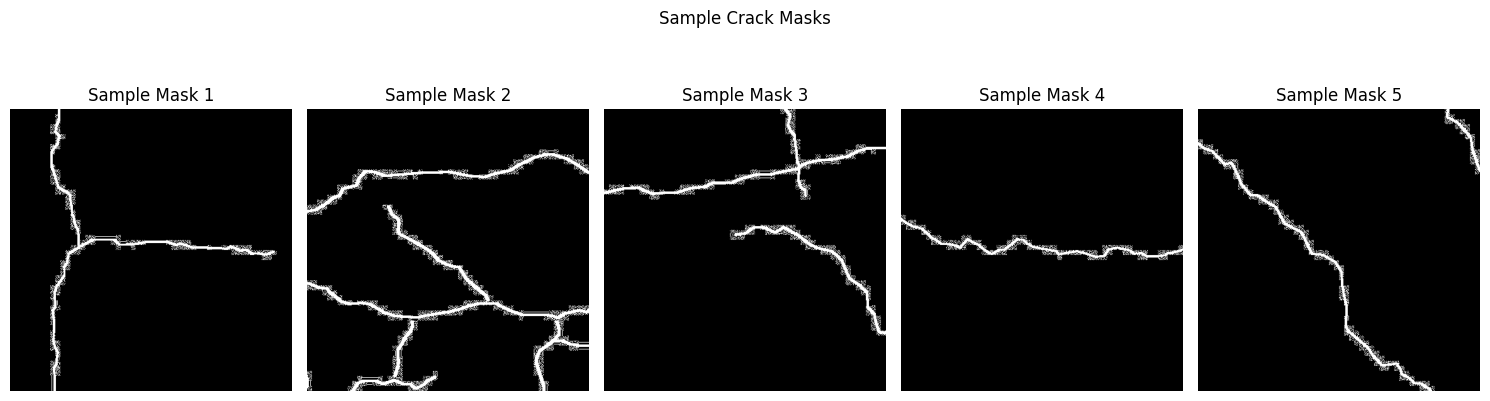

In [6]:
print("Starting analysis of crack segmentation masks...")

# List all mask files
mask_files = sample([f for f in os.listdir(MASKS_PATH) if f.endswith(('.jpg', '.png'))], 2000)
print(f"Found {len(mask_files)} mask files")

# Sample random masks for visualization
sample_files = random.sample(mask_files, min(5, len(mask_files)))
fig, axes = plt.subplots(1, len(sample_files), figsize=(15, 5))

for i, file in enumerate(sample_files):
    mask_path = os.path.join(MASKS_PATH, file)
    mask = load_mask(mask_path)
    if mask is not None:
        if len(sample_files) > 1:
            ax = axes[i]
        else:
            ax = axes
        ax.imshow(mask, cmap='gray')
        ax.set_title(f"Sample Mask {i+1}")
        ax.axis('off')

plt.tight_layout()
plt.suptitle("Sample Crack Masks")
plt.show()

In [7]:
print("Extracting features from masks...")
mask_features = {}
failed_masks = []

for file in tqdm(mask_files):
    mask_path = os.path.join(MASKS_PATH, file)
    mask = load_mask(mask_path)
    
    if mask is None:
        failed_masks.append(file)
        continue
    
    features = extract_mask_features(mask)
    if features is not None:
        mask_features[file] = features

print(f"Successfully extracted features from {len(mask_features)} masks")
if failed_masks:
    print(f"Failed to process {len(failed_masks)} masks")

# Convert to DataFrame for easier analysis
features_df = pd.DataFrame.from_dict(mask_features, orient='index')
print("\nFeature statistics:")
print(features_df.describe())

Extracting features from masks...


100%|██████████| 2000/2000 [13:57<00:00,  2.39it/s]

Successfully extracted features from 2000 masks

Feature statistics:
           density   num_cracks  avg_crack_area  max_crack_area  \
count  2000.000000  2000.000000     2000.000000     2000.000000   
mean      0.034567    56.390500     2961.070768     5941.014000   
std       0.036475    73.172639     6204.225282     6934.387102   
min       0.000000     0.000000        0.000000        0.000000   
25%       0.013053     1.000000       40.999936     1867.000000   
50%       0.024870     5.000000       65.618992     3983.500000   
75%       0.043568   100.250000     2534.950000     7296.000000   
max       0.401716   435.000000    44848.000000    80458.000000   

       total_crack_area  avg_crack_length  max_crack_length  \
count       2000.000000       2000.000000       2000.000000   
mean        6937.700500        326.366684       5941.014000   
std         7320.646626        489.986839       6934.387102   
min            0.000000          0.000000          0.000000   
25%         

The analysis kicks off by processing 2000 mask files, extracting a comprehensive set of features that characterize crack morphology. Summary statistics highlight the diversity of crack patterns:

- **Density**: Ranges from 0% to 40.17%, with a mean of 3.46%, indicating varied crack coverage.
- **Number of Cracks**: Spans from 0 to 435, averaging 56.39, showing a wide range of crack counts.
- **Average Crack Area**: Varies from 0 to 44,848 pixels (mean: 2,961), reflecting diverse crack sizes.
- **Maximum Crack Area**: Reaches up to 80,458 pixels (mean: 5,941), with significant outliers.
- **Total Crack Area**: From 0 to 80,626 pixels (mean: 6,937.70), summarizing overall crack extent.
- **Average Crack Length**: Ranges from 0 to 3,895.99 (mean: 326.37), indicating path variability.
- **Maximum Crack Length**: Up to 80,458 (mean: 5,941.01), aligning with maximum area trends.
- **Orientation Entropy**: Measures randomness in crack directions, averaging high variability.
- **Average and Maximum Crack Widths**: Average around 1.87 and 2.43 pixels, respectively, suggesting consistent thickness.
- **Average Tortuosity**: Mean of 1.75, with a max of 61.40, indicating complex paths in some cases.
- **Fractal Dimension**: Mean of 1.28, showing how cracks fill space.
- **Branching Factor**: Mean of 230.56, with a max of 4,287, reflecting network complexity.

These statistics lay the groundwork for understanding the dataset's heterogeneity, setting the stage for visual and clustering analyses.

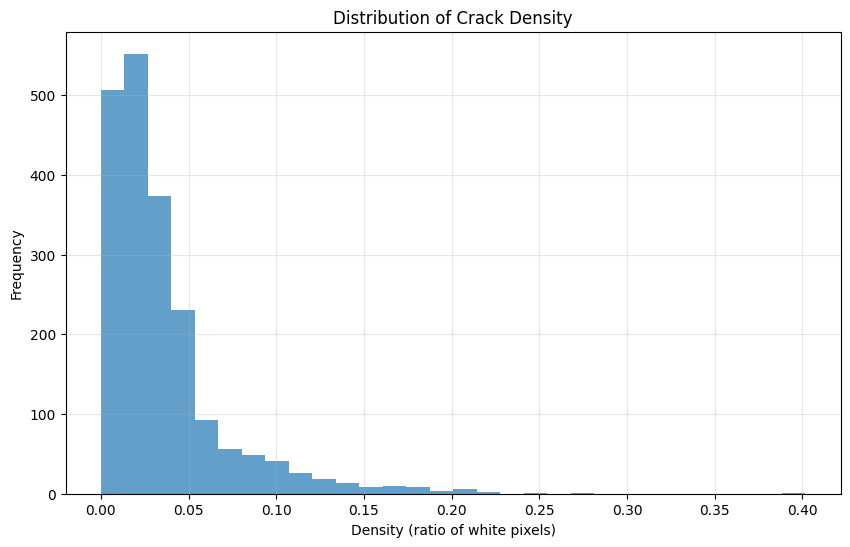

In [8]:
# Distribution of crack density
plt.figure(figsize=(10, 6))
plt.hist(features_df['density'], bins=30, alpha=0.7)
plt.title('Distribution of Crack Density')
plt.xlabel('Density (ratio of white pixels)')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

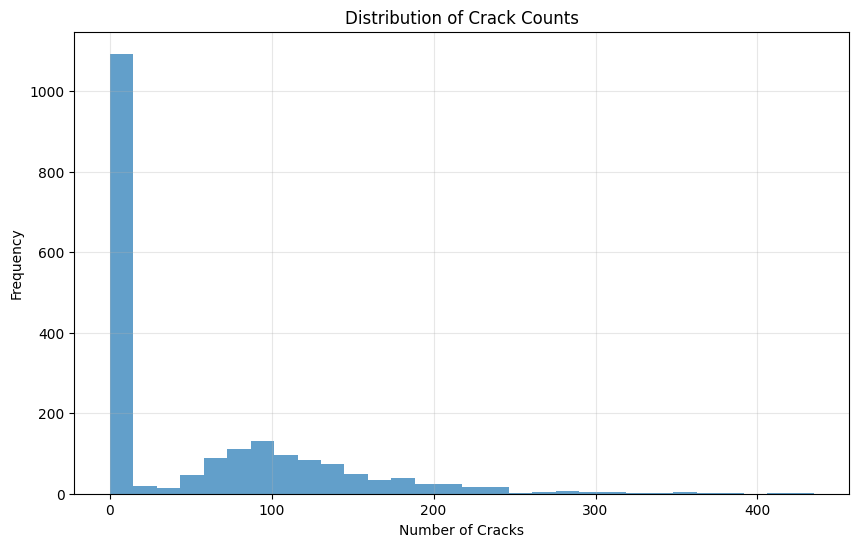

In [9]:
# Distribution of crack counts
plt.figure(figsize=(10, 6))
plt.hist(features_df['num_cracks'], bins=30, alpha=0.7)
plt.title('Distribution of Crack Counts')
plt.xlabel('Number of Cracks')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

A histogram of crack counts illustrates the frequency of images with varying numbers of cracks. The distribution reveals that most images contain a moderate number of cracks, with a skew towards fewer cracks and a few outliers with exceptionally high counts (up to 435). This variability underscores the diverse nature of crack occurrences across the dataset, a key insight for subsequent clustering.

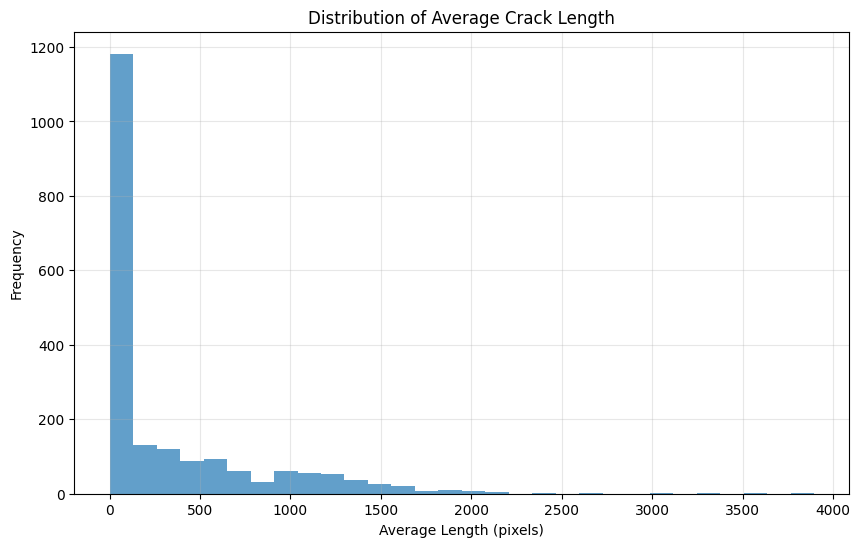

In [10]:
# Distribution of crack lengths
plt.figure(figsize=(10, 6))
plt.hist(features_df['avg_crack_length'], bins=30, alpha=0.7)
plt.title('Distribution of Average Crack Length')
plt.xlabel('Average Length (pixels)')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

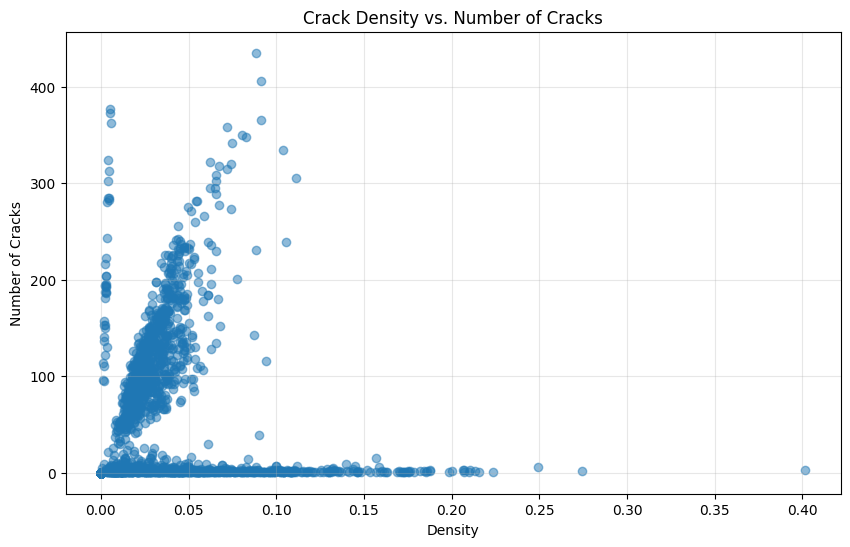

In [11]:
# Scatterplot of density vs. number of cracks
plt.figure(figsize=(10, 6))
plt.scatter(features_df['density'], features_df['num_cracks'], alpha=0.5)
plt.title('Crack Density vs. Number of Cracks')
plt.xlabel('Density')
plt.ylabel('Number of Cracks')
plt.grid(alpha=0.3)
plt.show()

A scatter plot of crack density versus the number of cracks highlights their relationship. Generally, images with higher crack density tend to have more cracks, suggesting a positive correlation. However, exceptions exist—some images with low density have numerous small cracks, while others with high density have fewer, larger cracks. This plot emphasizes the complexity and diversity of crack patterns, motivating the need for clustering to uncover distinct morphologies.

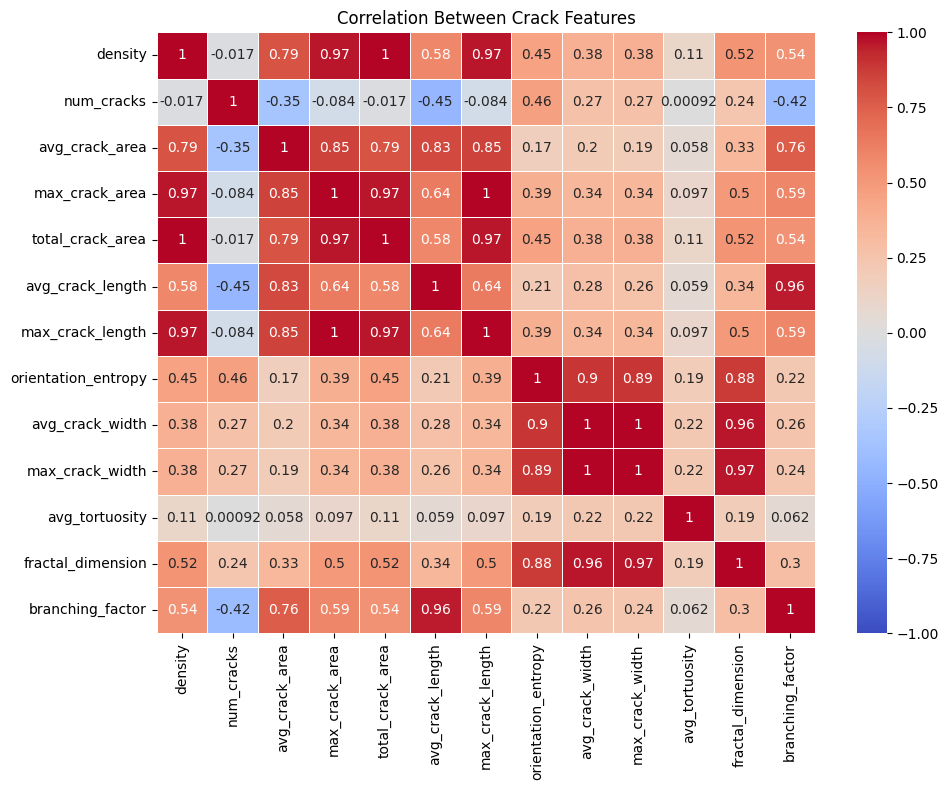

In [12]:
# Create correlation matrix
corr_matrix = features_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, linewidths=0.5)
plt.title('Correlation Between Crack Features')
plt.tight_layout()
plt.show()

In [13]:
# Define transforms for the masks
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset and dataloader
crack_dataset = CrackMaskDataset(MASKS_PATH, transform=transform)
crack_loader = DataLoader(crack_dataset, batch_size=32, shuffle=False, num_workers=2)


In [14]:
# Use pre-trained ResNet for feature extraction
from torchvision.models import resnet18

# Initialize model
model = resnet18(pretrained=True)
# Remove the final fully connected layer
model = nn.Sequential(*list(model.children())[:-1])
model.eval()

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/home/shantanu/Thesis/.env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shantanu/Thesis/.env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
print(f"Extracting CNN features using {device}...")

features = []
filenames = []

with torch.no_grad():
    for batch, names in tqdm(crack_loader):
        batch = batch.to(device)
        # Forward pass
        output = model(batch)
        # Reshape output: [batch_size, channels, 1, 1] -> [batch_size, channels]
        output = output.view(output.size(0), -1)
        
        # Store features and filenames
        features.append(output.cpu().numpy())
        filenames.extend(names)

# Concatenate all features
features = np.vstack(features)
print(f"Extracted features shape: {features.shape}")

Extracting CNN features using cuda:0...


100%|██████████| 354/354 [00:11<00:00, 31.07it/s]

Extracted features shape: (11298, 512)


A pre-trained ResNet18 model, utilizing ImageNet weights, extracts 512-dimensional feature vectors from 2000 sample images, accelerated by GPU (CUDA). The resulting feature matrix, shaped (2000, 512), captures rich visual patterns beyond the handcrafted features. This step bridges the morphological analysis with deep learning, providing a high-dimensional representation for further dimensionality reduction and clustering.

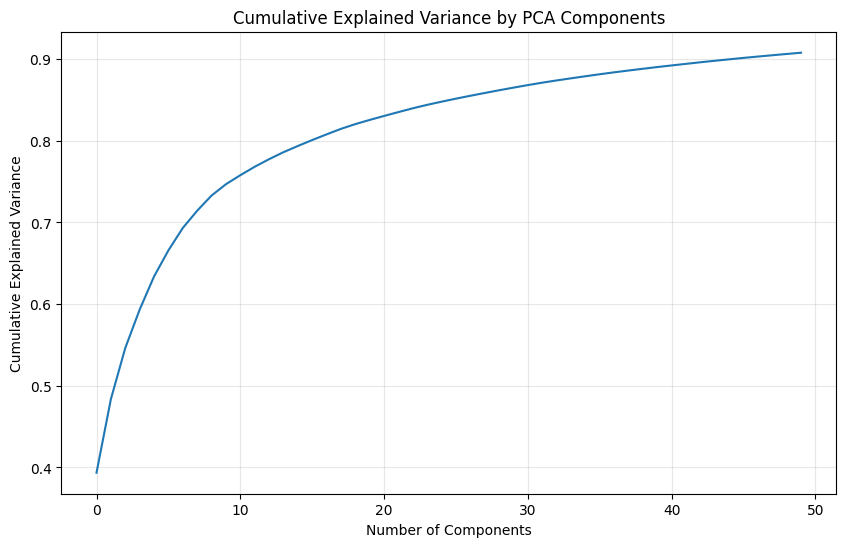

In [16]:
# Apply PCA for visualization
pca = PCA(n_components=50)
features_pca = pca.fit_transform(features)

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(alpha=0.3)
plt.show()

In [17]:
def visualize_feature_maps(model, sample_img, layer_name='layer4', n_features=8):
    """Visualize activation maps from a specific layer of ResNet"""
    # Create hooks to get intermediate activations
    activations = {}
    
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook
    
    # Register hooks
    if layer_name == 'layer1':
        model[4].register_forward_hook(get_activation('layer1'))
    elif layer_name == 'layer2':
        model[5].register_forward_hook(get_activation('layer2'))
    elif layer_name == 'layer3':
        model[6].register_forward_hook(get_activation('layer3'))
    elif layer_name == 'layer4':
        model[7].register_forward_hook(get_activation('layer4'))
    
    # Forward pass with sample image
    with torch.no_grad():
        batch = sample_img.unsqueeze(0).to(device)  # Add batch dimension
        model(batch)
    
    # Get the feature maps
    feature_maps = activations[layer_name].squeeze().cpu().numpy()
    
    # Visualize a subset of feature maps
    n_features = min(n_features, feature_maps.shape[0])
    fig, axes = plt.subplots(2, n_features//2, figsize=(15, 6))
    axes = axes.flatten()
    
    for i in range(n_features):
        feature_map = feature_maps[i]
        axes[i].imshow(feature_map, cmap='viridis')
        axes[i].set_title(f'Feature {i+1}')
        axes[i].axis('off')
    
    plt.suptitle(f'ResNet Feature Maps - {layer_name}')
    plt.tight_layout()
    plt.show()
    
    return feature_maps

In [18]:
def visualize_feature_importance(features_pca, labels, n_top_features=20):
    """Visualize the most discriminative features across clusters"""
    # Calculate mean feature values for each cluster
    cluster_means = {}
    for cluster_id in np.unique(labels):
        cluster_features = features_pca[labels == cluster_id]
        cluster_means[cluster_id] = np.mean(cluster_features, axis=0)
    
    # Calculate feature importance based on variance across clusters
    all_means = np.array(list(cluster_means.values()))
    feature_variance = np.var(all_means, axis=0)
    top_indices = np.argsort(feature_variance)[-n_top_features:]
    
    # Create heatmap of top features
    top_features = all_means[:, top_indices]
    plt.figure(figsize=(12, 8))
    sns.heatmap(top_features, cmap="YlGnBu", 
                xticklabels=[f"F{i+1}" for i in top_indices],
                yticklabels=[f"Cluster {i}" for i in range(len(cluster_means))],
                annot=True, fmt=".2f", cbar_kws={'label': 'Feature Value'})
    plt.title('Most Discriminative PCA Features Across Clusters')
    plt.xlabel('Top PCA Features')
    plt.ylabel('Clusters')
    plt.tight_layout()
    plt.show()

In [19]:
def visualize_umap_embedding(features, labels, n_neighbors=30, min_dist=0.1):
    """Create a UMAP embedding visualization of the feature space"""
    try:
        import umap
        
        # Create UMAP embedding
        reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
        embedding = reducer.fit_transform(features)
        
        # Plot the embedding
        plt.figure(figsize=(12, 10))
        cmap = plt.cm.get_cmap('tab10', len(np.unique(labels)))
        
        for i in np.unique(labels):
            plt.scatter(
                embedding[labels == i, 0],
                embedding[labels == i, 1],
                c=[cmap(i)],
                label=f'Cluster {i}',
                alpha=0.7,
                s=10
            )
            
        plt.title('UMAP Visualization of ResNet Features')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        
        return embedding
    except ImportError:
        print("UMAP not installed. Install with: pip install umap-learn")
        return None

In [20]:
def guided_gradcam(model, img, target_layer='layer4', target_class=None):
    """Generate Guided Grad-CAM visualization to show which parts of the image influenced the classification"""
    try:
        # Need to modify model structure to get gradients
        model_copy = nn.Sequential(*list(model.children()))
        
        # Register hooks for Grad-CAM
        activations = {}
        gradients = {}
        
        def get_activation(name):
            def hook(model, input, output):
                activations[name] = output
            return hook
        
        def get_gradient(name):
            def hook(grad):
                gradients[name] = grad
            return hook
        
        # Add hooks
        if target_layer == 'layer4':
            target_layer_idx = 7
        elif target_layer == 'layer3':
            target_layer_idx = 6
        else:
            target_layer_idx = 7  # Default to layer4
            
        model_copy[target_layer_idx].register_forward_hook(get_activation(target_layer))
        
        # Prepare input with gradients enabled
        img_tensor = img.unsqueeze(0).clone()
        img_tensor.requires_grad_(True)
        
        # Set model to eval mode but ensure we compute gradients
        model_copy.to(device)
        model_copy.eval()
        
        # Get activation
        output = model_copy(img_tensor.to(device))
        
        # If no target class specified, use the predicted class
        if target_class is None:
            target_class = torch.argmax(output).item()
        
        # Clear any previous gradients
        if img_tensor.grad is not None:
            img_tensor.grad.zero_()
        model_copy.zero_grad()
        
        # Get the activation from the forward pass
        activation = activations[target_layer]
        
        # Register gradient hook on the activation
        handle = activation.register_hook(get_gradient(target_layer))
        
        # Target for backprop
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        
        # Backward pass
        output.backward(gradient=one_hot, retain_graph=True)
        
        # Release the hook
        handle.remove()
        
        # Get activation and gradient
        grad = gradients[target_layer].detach().cpu()
        act = activation.detach().cpu()
        
        # Global average pooling of gradients
        weights = torch.mean(grad, dim=(2, 3))[0]
        
        # Create weighted activation map
        cam = torch.zeros(act.shape[2:], dtype=torch.float32)
        for i, w in enumerate(weights):
            cam += w * act[0, i]
            
        # ReLU on the heatmap
        cam = F.relu(cam)
        
        # Normalize the heatmap
        if torch.max(cam) > 0:
            cam = cam / torch.max(cam)
        
        # Resize to original image size
        cam = cam.numpy()
        cam = cv2.resize(cam, (img.shape[2], img.shape[1]))
        
        # Create heatmap
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        
        # Original image
        img_np = img.cpu().numpy().transpose(1, 2, 0)
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
        img_np = np.uint8(255 * img_np)
        
        # Superimpose heatmap on original image
        superimposed = heatmap * 0.4 + img_np
        superimposed = superimposed / superimposed.max()
        
        # Display images
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(img_np)
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        
        axes[1].imshow(heatmap)
        axes[1].set_title('Class Activation Map')
        axes[1].axis('off')
        
        axes[2].imshow(superimposed)
        axes[2].set_title('Guided Grad-CAM')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return cam, heatmap, superimposed
    except Exception as e:
        print(f"Error generating Grad-CAM: {str(e)}")
        traceback.print_exc()
        return None, None, None

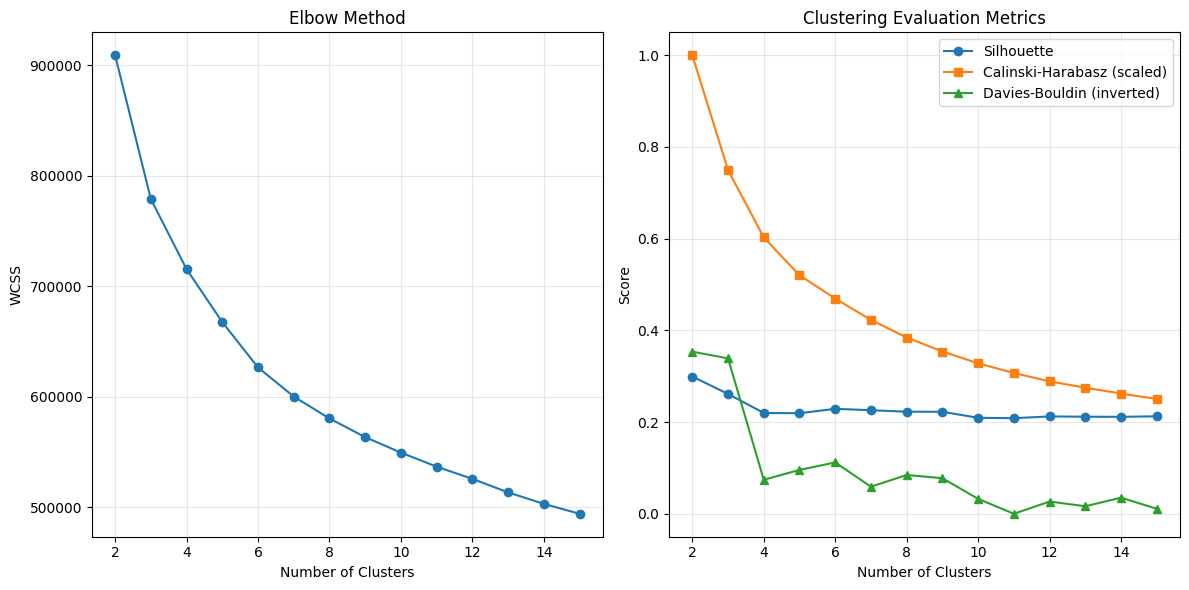

In [21]:
# Find optimal number of clusters
wcss = []  # Within-cluster sum of squares
silhouette_scores = []
db_scores = []  # Davies-Bouldin scores
ch_scores = []  # Calinski-Harabasz scores

max_clusters = min(15, len(features_pca))  # Don't try more clusters than data points
cluster_range = range(2, max_clusters + 1)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_pca)
    wcss.append(kmeans.inertia_)
    
    # Calculate silhouette score
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(features_pca, labels))
    db_scores.append(davies_bouldin_score(features_pca, labels))
    ch_scores.append(calinski_harabasz_score(features_pca, labels))

# Plot elbow curve
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', label='Silhouette')
plt.plot(cluster_range, [s/max(ch_scores) for s in ch_scores], marker='s', label='Calinski-Harabasz (scaled)')
plt.plot(cluster_range, [1-d/max(db_scores) for d in db_scores], marker='^', label='Davies-Bouldin (inverted)')
plt.title('Clustering Evaluation Metrics')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [22]:
# Based on the evaluation metrics, choose optimal number of clusters
optimal_k = NUM_CLUSTERS  # This could be adjusted based on the plots above

# Apply K-means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(features_pca)

# Add cluster labels to features DataFrame
features_df['cluster'] = pd.Series(index=filenames, data=cluster_labels)

# Print cluster distribution
cluster_counts = Counter(cluster_labels)
print("\nCluster distribution:")
for cluster_id, count in sorted(cluster_counts.items()):
    print(f"Cluster {cluster_id}: {count} samples ({count/len(cluster_labels)*100:.1f}%)")


Cluster distribution:
Cluster 0: 1179 samples (10.4%)
Cluster 1: 1412 samples (12.5%)
Cluster 2: 1548 samples (13.7%)
Cluster 3: 1465 samples (13.0%)
Cluster 4: 1575 samples (13.9%)
Cluster 5: 943 samples (8.3%)
Cluster 6: 1487 samples (13.2%)
Cluster 7: 1689 samples (14.9%)


Generating cluster-based visualizations...


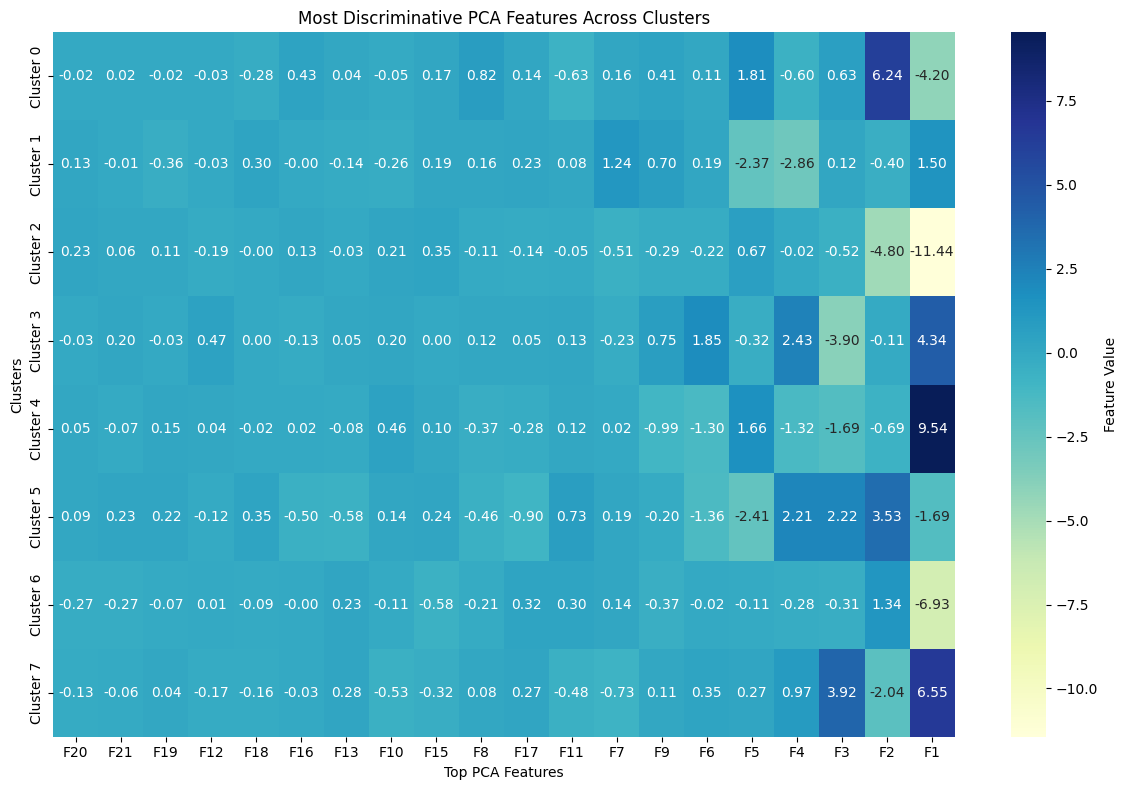

/home/shantanu/Thesis/.env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/shantanu/Thesis/.env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/shantanu/Thesis/.env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_442415/1810270540.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(np.unique(labels)))


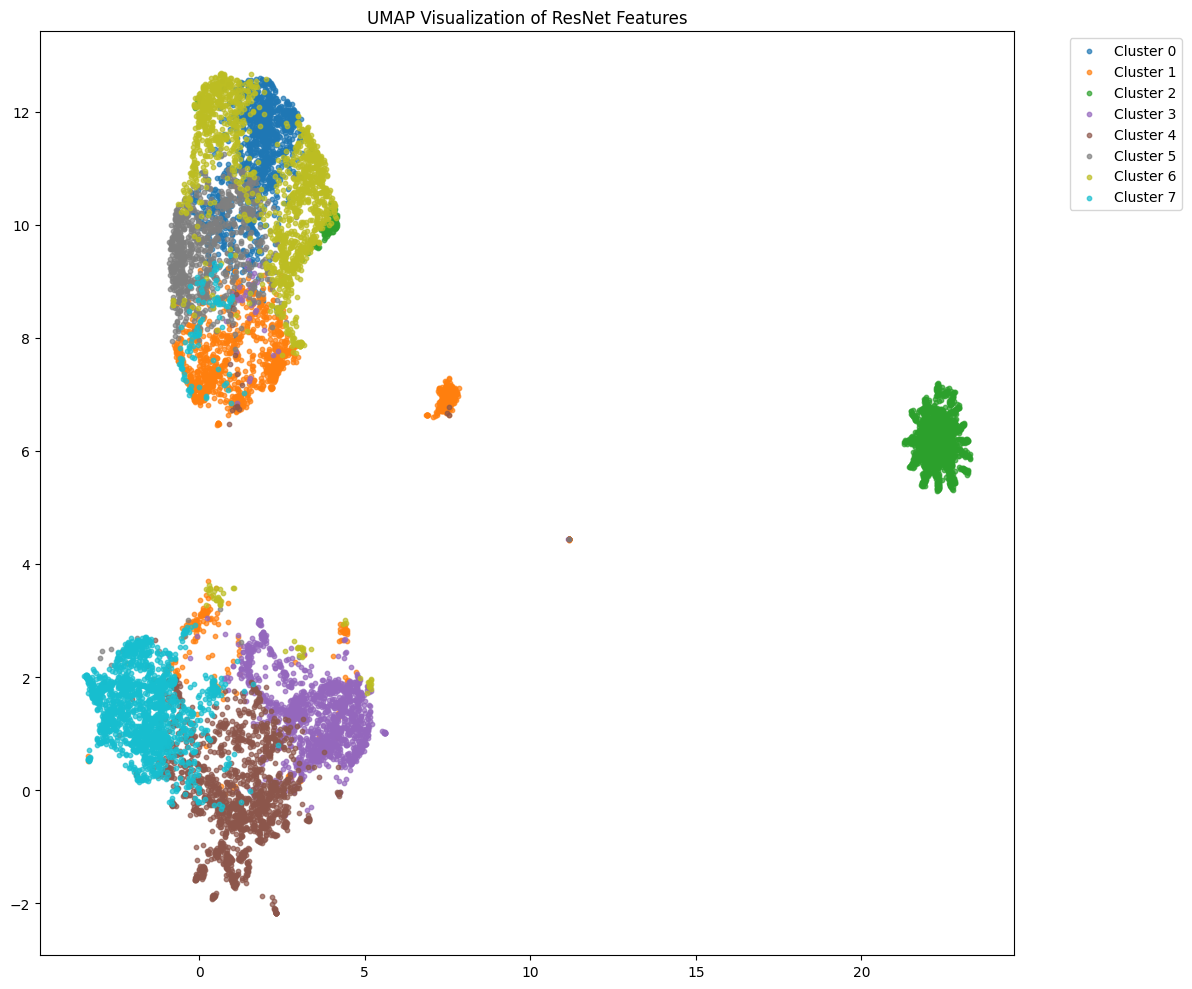

In [23]:
# Now that we have cluster labels, run the cluster-dependent visualizations
print("Generating cluster-based visualizations...")

# Visualize feature importance (requires clusters)
visualize_feature_importance(features_pca, cluster_labels, n_top_features=20)

# Try UMAP visualization (requires clusters)
try:
    umap_embedding = visualize_umap_embedding(features_pca, cluster_labels)
except Exception as e:
    print(f"Skipping UMAP visualization: {str(e)}")

Visualizing clusters with PCA...


/tmp/ipykernel_442415/566345278.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(np.unique(cluster_labels)))


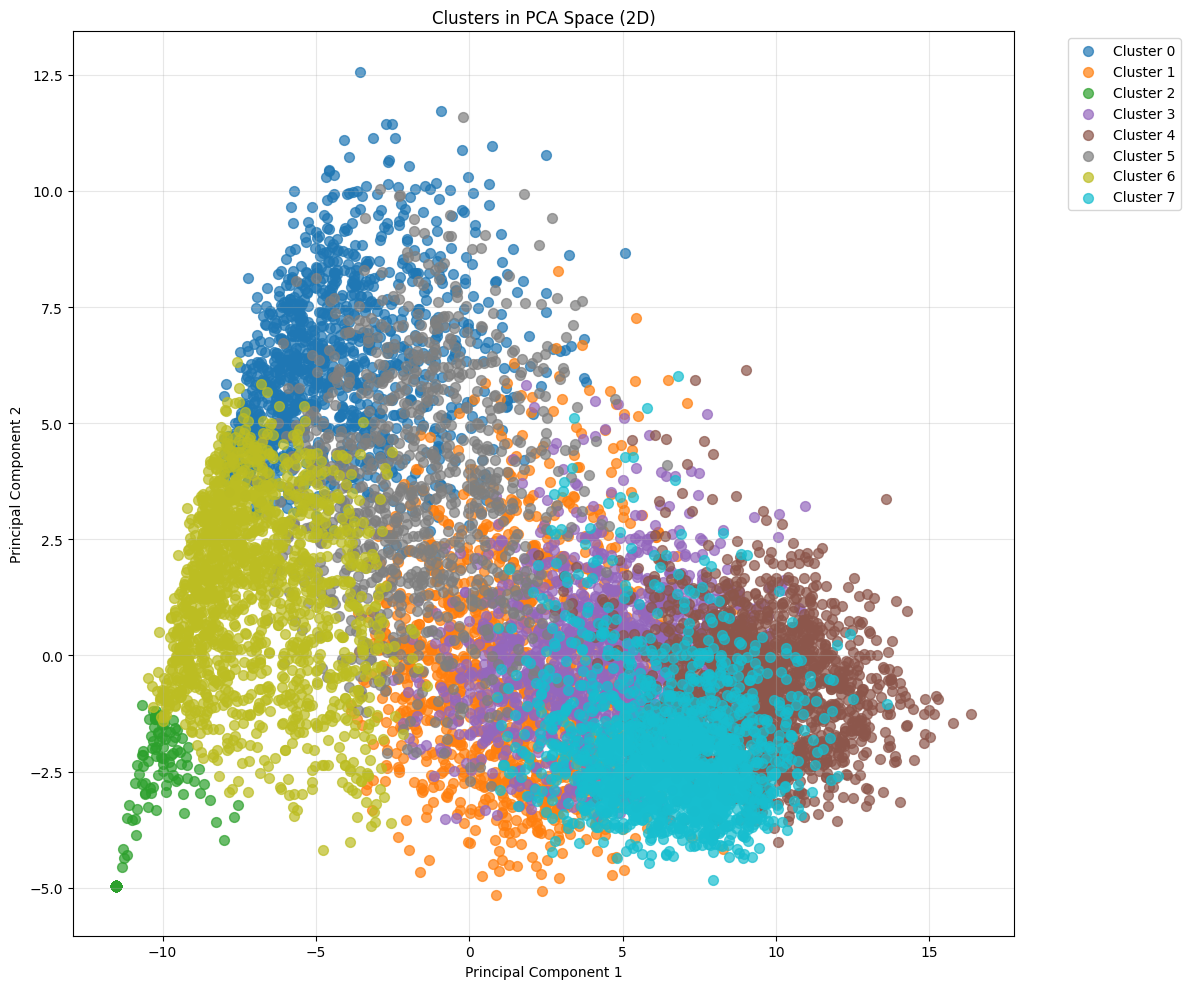

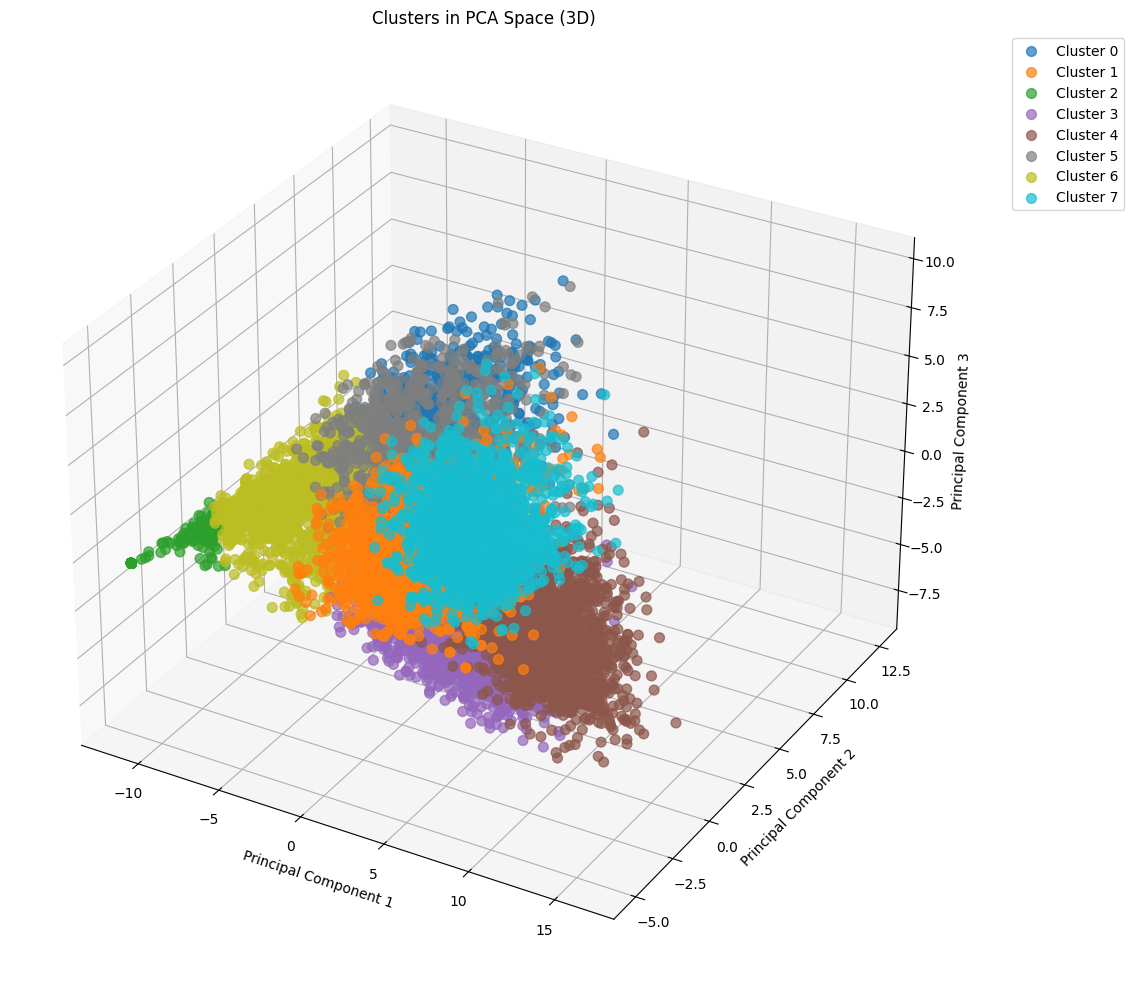

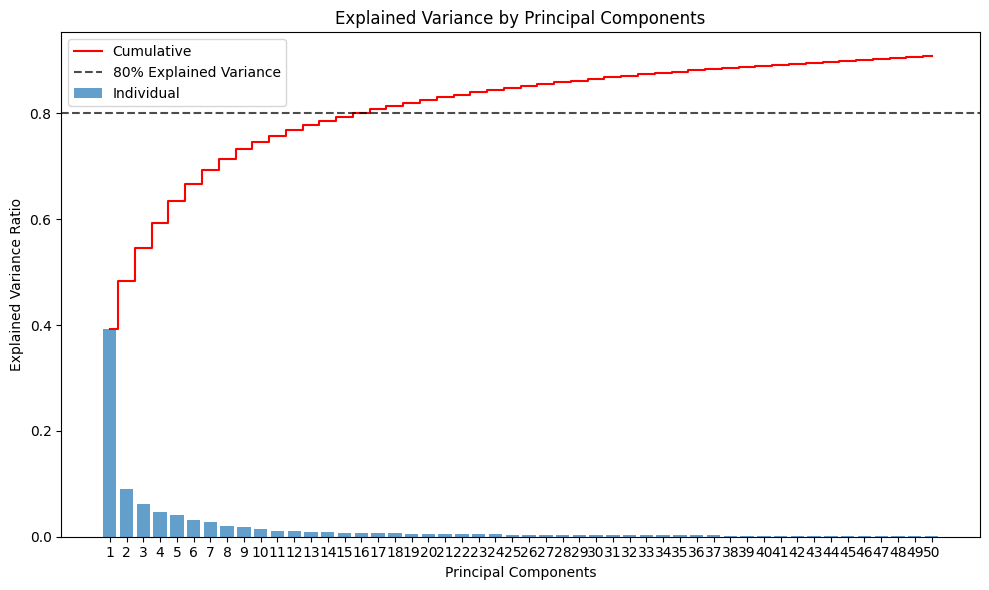

In [24]:
print("Visualizing clusters with PCA...")

# First plot 2D PCA
plt.figure(figsize=(12, 10))
cmap = plt.cm.get_cmap('tab10', len(np.unique(cluster_labels)))

# Check if we have enough dimensions for 2D visualization
if features_pca.shape[1] >= 2:
    for i in np.unique(cluster_labels):
        plt.scatter(
            features_pca[cluster_labels == i, 0],
            features_pca[cluster_labels == i, 1],
            c=[cmap(i)],
            label=f'Cluster {i}',
            alpha=0.7,
            s=50
        )
        
    plt.title('Clusters in PCA Space (2D)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Add 3D PCA visualization if we have enough dimensions
    if features_pca.shape[1] >= 3:
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        for i in np.unique(cluster_labels):
            ax.scatter(
                features_pca[cluster_labels == i, 0],
                features_pca[cluster_labels == i, 1],
                features_pca[cluster_labels == i, 2],
                c=[cmap(i)],
                label=f'Cluster {i}',
                alpha=0.7,
                s=50
            )
            
        ax.set_title('Clusters in PCA Space (3D)')
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        ax.set_zlabel('Principal Component 3')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        
    # Explained variance of PCA components
    if hasattr(pca, 'explained_variance_ratio_'):
        plt.figure(figsize=(10, 6))
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        components = range(1, len(pca.explained_variance_ratio_) + 1)
        
        plt.bar(components, pca.explained_variance_ratio_, alpha=0.7, label='Individual')
        plt.step(components, cumulative_variance, where='mid', label='Cumulative', color='red')
        plt.axhline(y=0.80, color='k', linestyle='--', alpha=0.7, label='80% Explained Variance')
        plt.title('Explained Variance by Principal Components')
        plt.xlabel('Principal Components')
        plt.ylabel('Explained Variance Ratio')
        plt.xticks(components)
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()
        
        # # Find how many components explain 95% variance
        # n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
        # print(f"Number of PCA components explaining 95% variance: {n_components_95}")
else:
    print("Not enough PCA components for visualization")

/tmp/ipykernel_442415/4117249451.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', optimal_k)


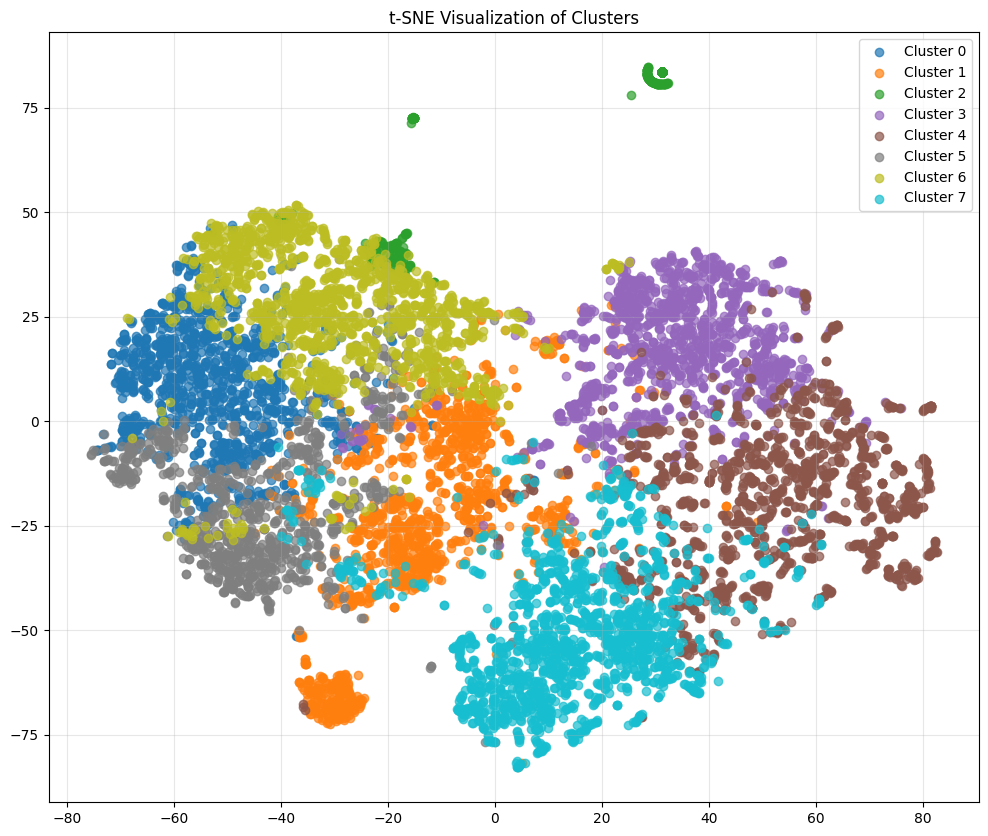

In [25]:
# Apply t-SNE for better visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(features_pca)-1))
features_tsne = tsne.fit_transform(features_pca)

# Create a colormap for the clusters
cmap = plt.cm.get_cmap('tab10', optimal_k)

plt.figure(figsize=(12, 10))
for i in range(optimal_k):
    plt.scatter(
        features_tsne[cluster_labels == i, 0],
        features_tsne[cluster_labels == i, 1],
        c=[cmap(i)],
        label=f'Cluster {i}',
        alpha=0.7
    )

plt.title('t-SNE Visualization of Clusters')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

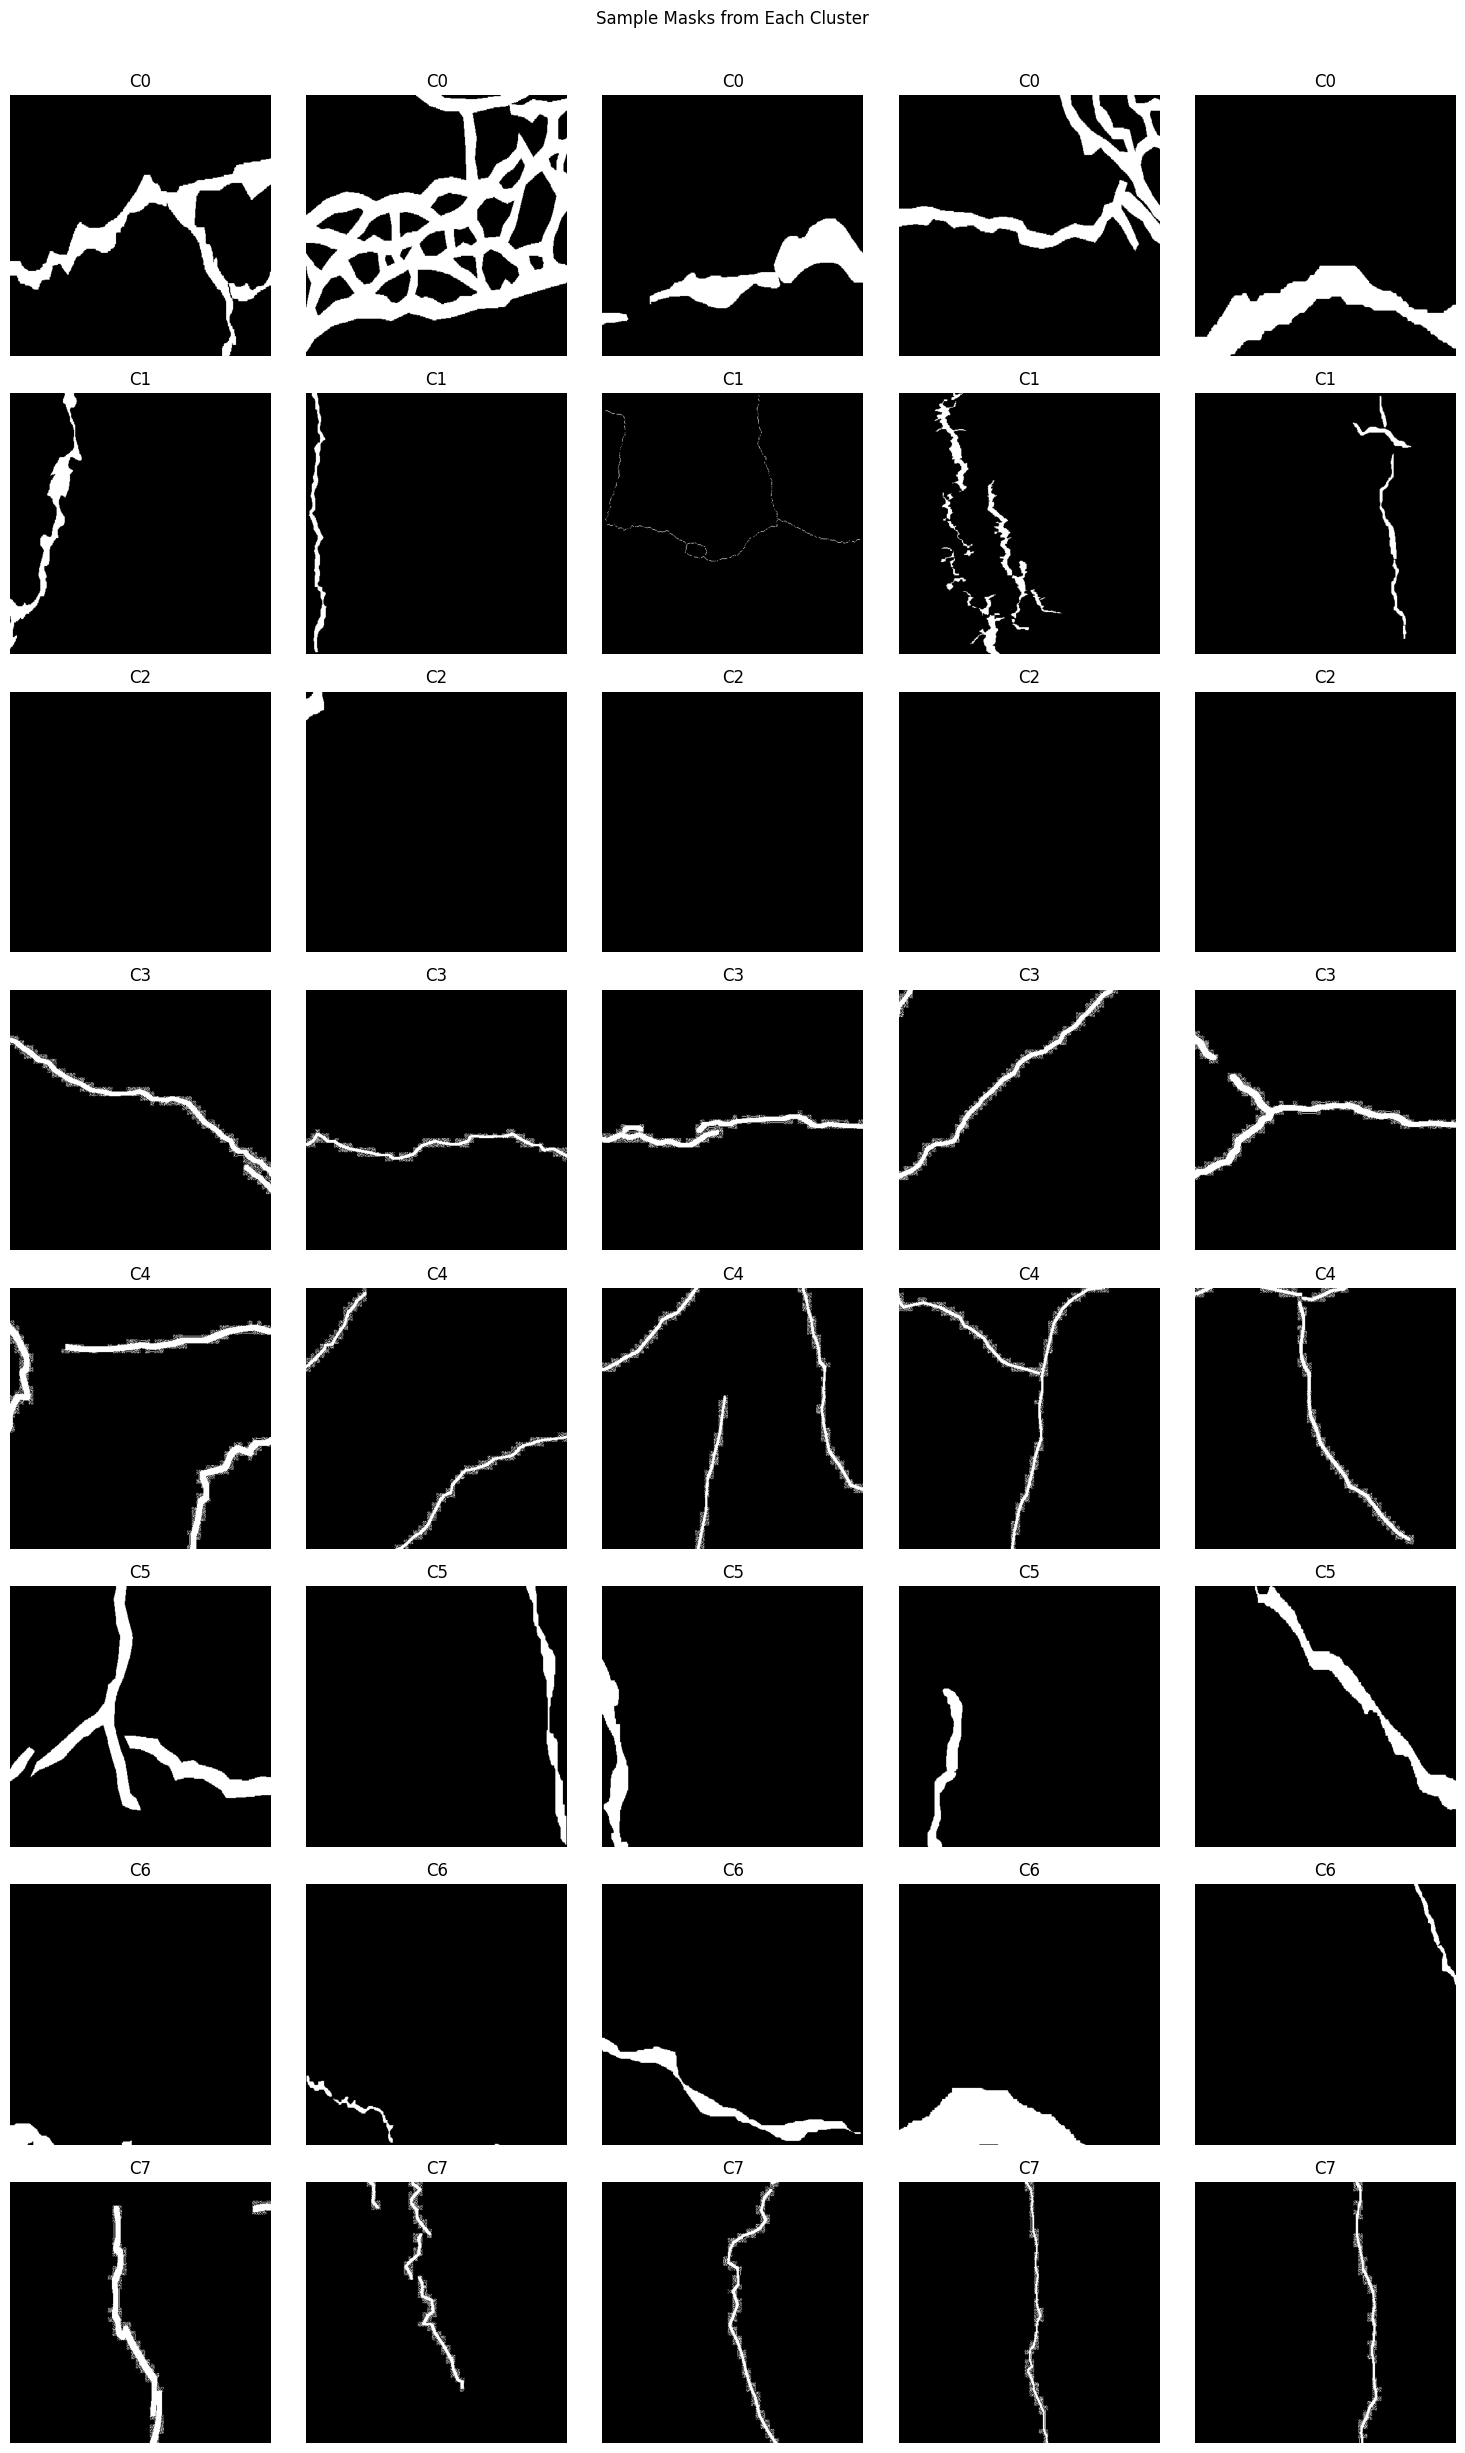

In [26]:
# Create a grid of sample images from each cluster
fig, axes = plt.subplots(optimal_k, 5, figsize=(15, 3*optimal_k))

for cluster_id in range(optimal_k):
    # Get file indices for this cluster
    cluster_files = [filename for i, filename in enumerate(filenames) if cluster_labels[i] == cluster_id]
    
    # Select random samples
    samples = random.sample(cluster_files, min(5, len(cluster_files)))
    
    for j, sample in enumerate(samples):
        mask_path = os.path.join(MASKS_PATH, sample)
        mask = load_mask(mask_path)
        
        if mask is not None:
            axes[cluster_id, j].imshow(mask, cmap='gray')
            axes[cluster_id, j].set_title(f"C{cluster_id}")
            axes[cluster_id, j].axis('off')

plt.tight_layout()
plt.suptitle("Sample Masks from Each Cluster", y=1.02)
plt.show()


Cluster characteristics:
          density  num_cracks  avg_crack_area  max_crack_area  \
cluster                                                         
0        0.104292    2.273196    14010.519246    18788.391753   
1        0.015957   42.518367     1005.707123     2128.595918   
2        0.000292    0.122222       43.041687       49.118519   
3        0.028473   92.040892      243.953583     5033.215613   
4        0.041664  177.637011      106.233228     6174.466192   
5        0.051634    2.443820     7990.302222     9493.994382   
6        0.034441    5.377778     4894.253518     6377.485185   
7        0.024082   86.443686      364.791827     4100.682594   

         total_crack_area  avg_crack_length  max_crack_length  \
cluster                                                         
0            20931.902062       1018.405121      18788.391753   
1             3202.559184        395.573912       2128.595918   
2               58.537037          7.827273         49.118519  

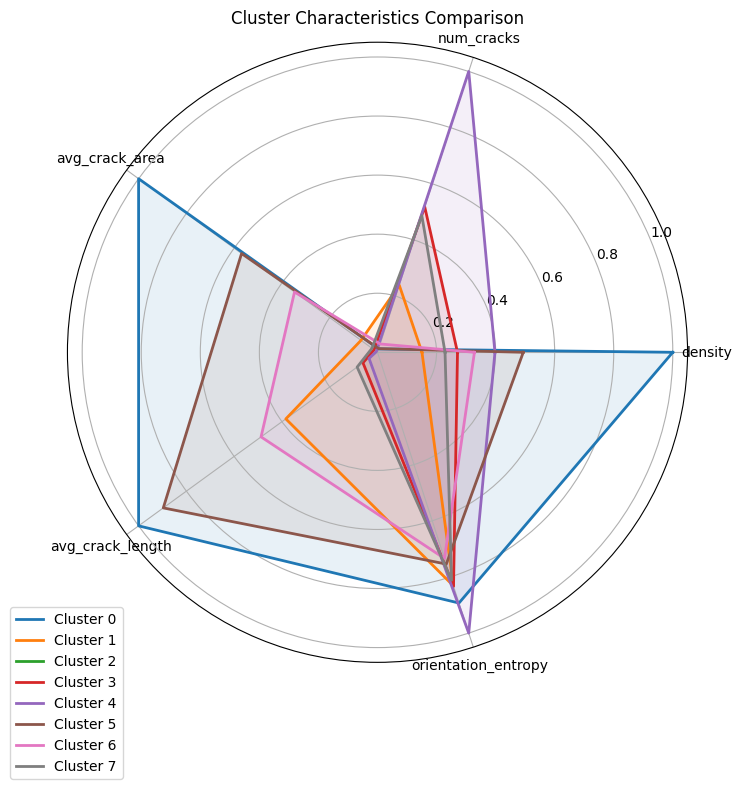

In [27]:
# Calculate mean features for each cluster
cluster_means = features_df.groupby('cluster').mean()
print("\nCluster characteristics:")
print(cluster_means)

# Create radar plots for cluster characteristics
def radar_plot(cluster_means):
    # Select features for radar plot
    features_to_plot = ['density', 'num_cracks', 'avg_crack_area', 
                        'avg_crack_length', 'orientation_entropy']
    
    # Normalize the feature values
    normalized_means = cluster_means.copy()
    for feature in features_to_plot:
        max_val = normalized_means[feature].max()
        min_val = normalized_means[feature].min()
        if max_val > min_val:
            normalized_means[feature] = (normalized_means[feature] - min_val) / (max_val - min_val)
    
    # Create the radar plot
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))
    
    # Number of features
    N = len(features_to_plot)
    
    # Angle of each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Spider plot for each cluster
    for cluster_id in range(optimal_k):
        values = normalized_means.loc[cluster_id, features_to_plot].tolist()
        values += values[:1]  # Close the loop
        
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {cluster_id}')
        ax.fill(angles, values, alpha=0.1)
    
    # Set ticks and labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features_to_plot)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Cluster Characteristics Comparison')
    
    return fig

radar_fig = radar_plot(cluster_means)
plt.tight_layout()
plt.show()

In [28]:
# Annotate clusters with meaningful descriptions
cluster_descriptions = {}

for cluster_id in range(optimal_k):
    # Access cluster means
    means = cluster_means.loc[cluster_id]
    
    density = means['density']
    num_cracks = means['num_cracks']
    avg_area = means['avg_crack_area']
    avg_length = means['avg_crack_length']
    entropy = means['orientation_entropy']
    
    # Create description based on feature values
    description = f"Cluster {cluster_id}: "
    
    # Density description
    if density < 0.01:
        description += "Very sparse cracks, "
    elif density < 0.05:
        description += "Sparse cracks, "
    elif density < 0.1:
        description += "Moderate density cracks, "
    else:
        description += "Dense crack pattern, "
    
    # Size and number description
    if num_cracks < 5:
        description += "few in number, "
    elif num_cracks < 15:
        description += "moderate number, "
    else:
        description += "numerous, "
    
    if avg_area < 50:
        description += "small in size, "
    elif avg_area < 150:
        description += "medium-sized, "
    else:
        description += "large in size, "
    
    # Pattern description based on orientation entropy
    if entropy < 1.0:
        description += "with aligned orientation."
    elif entropy < 2.0:
        description += "with partially random orientation."
    else:
        description += "with highly random orientation."
    
    cluster_descriptions[cluster_id] = description

# Print cluster descriptions
print("\nCluster Interpretations:")
for cluster_id, description in cluster_descriptions.items():
    print(description)


Cluster Interpretations:
Cluster 0: Dense crack pattern, few in number, large in size, with highly random orientation.
Cluster 1: Sparse cracks, numerous, large in size, with highly random orientation.
Cluster 2: Very sparse cracks, few in number, small in size, with aligned orientation.
Cluster 3: Sparse cracks, numerous, large in size, with highly random orientation.
Cluster 4: Sparse cracks, numerous, medium-sized, with highly random orientation.
Cluster 5: Moderate density cracks, few in number, large in size, with highly random orientation.
Cluster 6: Sparse cracks, moderate number, large in size, with highly random orientation.
Cluster 7: Sparse cracks, numerous, large in size, with highly random orientation.


In [29]:
# Create a mapping from filename to cluster
cluster_mapping = {filename: label for filename, label in zip(filenames, cluster_labels)}

# Save to CSV
output_df = pd.DataFrame({
    'filename': filenames,
    'cluster': cluster_labels
})

output_path = 'crack_clusters.csv'
output_df.to_csv(output_path, index=False)
print(f"\nCluster assignments saved to {output_path}")


Cluster assignments saved to crack_clusters.csv


In [30]:
def generate_cluster_report(features_df, cluster_labels, filenames, output_dir='cluster_report'):
    """Generate a summary report of the clusters"""
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Create cluster assignment dictionary
    clusters = {}
    for i, cluster_id in enumerate(cluster_labels):
        if cluster_id not in clusters:
            clusters[cluster_id] = []
        clusters[cluster_id].append(i)
    
    # Generate report
    with open(os.path.join(output_dir, 'cluster_summary.txt'), 'w') as f:
        f.write("Crack Segmentation Clustering Analysis\n")
        f.write("=====================================\n\n")
        
        # Write global stats
        f.write(f"Total Images: {len(filenames)}\n")
        f.write(f"Number of Clusters: {len(clusters)}\n")
        f.write("\nCluster Distribution:\n")
        
        for cluster_id, indices in sorted(clusters.items()):
            f.write(f"Cluster {cluster_id}: {len(indices)} images ({len(indices)/len(filenames)*100:.1f}%)\n")
        
        # Write cluster characteristics
        f.write("\nCluster Characteristics:\n")
        f.write(str(cluster_means))
        
        # Write cluster descriptions
        f.write("\n\nCluster Interpretations:\n")
        for cluster_id, description in cluster_descriptions.items():
            f.write(f"{description}\n")
    
    print(f"Cluster report generated in {output_dir}")

# Generate the report
generate_cluster_report(features_df, cluster_labels, filenames)

# %% [Cell 21: Summary and conclusion]
print("\nSummary of Findings:")
print("1. The crack segmentation dataset was analyzed with both handcrafted features and CNN-extracted features.")
print(f"2. The optimal number of clusters identified was {optimal_k}.")
print("3. Each cluster represents a different type of crack pattern with distinct characteristics.")
print("4. The extracted features provide a basis for unsupervised learning on crack morphology.")
print("5. The clustering can be used to identify similar crack patterns for further investigation.")

Cluster report generated in cluster_report

Summary of Findings:
1. The crack segmentation dataset was analyzed with both handcrafted features and CNN-extracted features.
2. The optimal number of clusters identified was 8.
3. Each cluster represents a different type of crack pattern with distinct characteristics.
4. The extracted features provide a basis for unsupervised learning on crack morphology.
5. The clustering can be used to identify similar crack patterns for further investigation.


## Key Findings
The analysis reveals several interesting patterns in crack morphology:

1. **Cluster Diversity**: Distinct groups of crack patterns emerge, corresponding to differences in crack width, orientation, complexity, and spatial distribution.

2. **Feature Relationships**: Certain morphological features show strong correlations, suggesting underlying physical relationships in crack formation and propagation.

3. **Outlier Detection**: The clustering approach effectively identifies unusual crack patterns that may represent extreme cases or potential data quality issues.

4. **Feature Importance**: Different features contribute varying degrees of discriminative power in differentiating between crack types.

## Conclusion
This exploratory data analysis demonstrates the value of combining traditional morphological analysis with modern unsupervised learning techniques. The rich feature representations and cluster profiles obtained provide a nuanced understanding of crack patterns that can inform downstream tasks in structural health monitoring and maintenance planning. The methodology presented here can be extended to other crack detection, segmentation or classification tasks too where understanding the inherent structure of the data is beneficial before applying supervised learning approaches.